**<font color = 'green'>**Desafío - Detección de cardiopatía**</font>**

Importamos las librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Modelos
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split,GridSearchCV

#Evaluacion
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve,precision_recall_curve
from xgboost import XGBRegressor, plot_importance


from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Carga los datos de los tres archivos unidos en un DataFrame, y prepáralos considerando las siguientes etapas:

a. asigna a la variable objetivo num un cero cuando su valor es cero, y un 1 en
otro caso. Muestra la cantidad de valores ausente por atributo. Procésalos
considerando los siguientes criterios:

+ i. si el atributo presenta un porcentaje de valores ausentes mayor a 25%,
entonces descartamos ese atributo.

+ ii. para los atributos con valores ausentes menores al 25% se deben
rellenar con el valor promedio del atributo de acuerdo a la clase, es
decir, los valores ausentes para los cuales num=0 se deben rellenar
con el promedio de los valores presentes para los cuales num=0.

+ iii. Para las variables categóricas, los valores a asignar (promedio) deben
ser aproximados al valor entero más cercano.

In [ ]:
#Cargamos los dataset
fnames = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/2.Modelos de ensamble Parte II/Desafio/feature_names.csv")
clev = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/2.Modelos de ensamble Parte II/Desafio/processed.cleveland.data")
hung = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/2.Modelos de ensamble Parte II/Desafio/processed.hungarian.data")
swit = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Redes neuronales/2.Modelos de ensamble Parte II/Desafio/processed.switzerland.data")

In [ ]:
# Extraemos los nombres de las columnas
header = [fnames.columns[0]]
column_names = header + fnames['age'].values.tolist()

#Renombramos los datasets
clev.rename(columns=dict(zip(clev.columns, column_names)), inplace=True)
hung.rename(columns=dict(zip(hung.columns, column_names)), inplace=True)
swit.rename(columns=dict(zip(swit.columns, column_names)), inplace=True)

#Crearemos una columna que nos indique a que clinica pertenecen los registros antes de unificar la data
clev["med_clinic"] = "cleveland"
hung["med_clinic"] = "hungarian"
swit["med_clinic"] = "switzerland"

#Concatenamos
df = pd.concat([clev,hung,swit])
df = df.rename(columns={"num":"target"}) #Cambiamos el nombre al target

**Revision de calidad de datos**

In [ ]:
def data_quality (df,df_name):
  #Dimension
  print("======= Revision de dimension ==========")
  print("")
  print(f"El shape de {df_name} es {df.shape}")
  print("")
  #Revision de valores nulls
  print("======= Revision de nulos ==========")
  print("")
  print(f"Cantidad de nulos por columna en el dataset {df_name}:")
  print("")
  for colname in df.columns:
    col_nulls= df[colname].isna().sum()
    print(f"{colname}: {col_nulls}")
  print("")

  #Revision dtypes
  print("")
  print("======= Revision dtypes ==========")
  print("")
  print(df.dtypes)

  #Revision de duplicados
  print("")
  print("======= Revision duplicados ==========")
  print("")
  print(f"Cantidad de duplicados en {df_name} : {df.duplicated().sum()}")

  #Revision de valores unicos, con esto podemos ver si las variables categoricas presentan valores erroneos, ya que los outliers solo aplican para numericas.
  print("")
  print("======= Revision valores unicos ==========")
  print("")
  for colname in df.columns:
    col_nunique= df[colname].nunique()
    print(f"{colname}: {col_nunique}")
  print("")

  #Valores unicos variables categoricas
  print("")
  print("======= Revision valores unicos categoricas ==========")
  print("")
  for colname in df.columns:
    if df[colname].dtypes not in ["int","float"]:
      col_unique= df[colname].unique()
      print(f"Columna {colname}:")
      print("")
      print(col_unique)
      print("")

In [ ]:
data_quality(df,"Dataset Clinicas Unificado")

======= Revision de dimension ==========

El shape de Dataset Clinicas Unificado es (717, 15)

======= Revision de nulos ==========

Cantidad de nulos por columna en el dataset Dataset Clinicas Unificado:

age: 0
sex: 0
cp: 0
threstbps: 0
chol: 0
fbs: 0
restecg: 0
thalach: 0
exang: 0
oldpeak: 0
slope: 0
ca: 0
thal: 0
target: 0
med_clinic: 0


======= Revision dtypes ==========

age           float64
sex           float64
cp            float64
threstbps      object
chol           object
fbs            object
restecg        object
thalach        object
exang          object
oldpeak        object
slope          object
ca             object
thal           object
target          int64
med_clinic     object
dtype: object

======= Revision duplicados ==========

Cantidad de duplicados en Dataset Clinicas Unificado : 1

======= Revision valores unicos ==========

age: 48
sex: 2
cp: 4
threstbps: 86
chol: 306
fbs: 5
restecg: 7
thalach: 188
exang: 5
oldpeak: 77
slope: 7
ca: 8
thal: 7
target: 5
me

Luego de esta revision de calidad de datos unificados, tendremos que hacer una limpieza y transformación para poder detectar y calcular correctamente la cantidad de valores ausentes, ya que más que nulos, hay datos erróneos.

In [ ]:
#a. Asignamos al target un 0 cuando es 0 y un 1 cuando es otro valor
df["target"] = np.where(df["target"]== 0,0,1)
#Transformamos los datos para que esten en formatos correctos de acuerdo a la naturaleza de cada variable
replace_categorical = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '1.0': 1,
    '2.0': 2,
    '3.0': 3,
    '4.0': 4,
    '5.0': 5,
    '6.0': 6,
    '7.0': 7,
    "?":np.nan
}

replace_chol = {0: np.nan,
                "?":np.nan}

replace_cont = {"?":np.nan}

#Reemplazamos los valores en las columnas numericas pero que representan categorias booleanas o multiclase
df["thal"].replace(replace_categorical,inplace=True)
df["ca"].replace(replace_categorical,inplace=True)
df["slope"].replace(replace_categorical,inplace=True)
df["exang"].replace(replace_categorical,inplace=True)
df["restecg"].replace(replace_categorical,inplace=True)
df["fbs"].replace(replace_categorical,inplace=True)

#Remplazamos en las variables continuas
df["chol"].replace(replace_chol,inplace=True)
df["thalach"].replace(replace_cont,inplace=True)
df["threstbps"].replace(replace_cont,inplace=True)

df['oldpeak'] = pd.to_numeric(df['oldpeak'], errors='coerce')
df["oldpeak"] = df["oldpeak"].apply(lambda x: np.nan if x < 0 else x ) #Por la naturaleza de la variable, no puede ser negativo
df["oldpeak"] = df["oldpeak"].apply(lambda x: np.nan if x == 0 else x )

#Transformamos los tipos de datos
df["sex"] = df["sex"].astype(int)
df["age"] = df["age"].astype(int)
df["cp"] = df["cp"].astype(int)
df["threstbps"] = df["threstbps"].astype(float)
df["chol"] = df["chol"].astype(float)
df["fbs"] = df["fbs"].astype(float)
df["restecg"] = df["restecg"].astype(float)
df["thalach"] = df["thalach"].astype(float)
df["exang"] = df["exang"].astype(float)
df["oldpeak"] = df["oldpeak"].astype(float)
df["slope"] = df["slope"].astype(float)
df["ca"] = df["ca"].astype(float)
df["thal"] = df["thal"].astype(float)


In [ ]:
#Calculamos que columnas deben ser eliminadas o imputadas según los puntos 1.a.1 , 2 y 3.
total = df.shape[0]
corte = total*0.25

print(f"Total registros {total}, corte de 25% serían {corte}")
print()
for col in df.columns:
  nulls = df[col].isnull().sum()
  if nulls > corte:
    print(col, f"     Se descarta el atributo por tener nulos mayores al %25, con {nulls} registros nulos")
  else:
    print(col, f"     Se conserva el atributo con solo {nulls} nulos")

Total registros 717, corte de 25% serían 179.25

age      Se conserva el atributo con solo 0 nulos
sex      Se conserva el atributo con solo 0 nulos
cp      Se conserva el atributo con solo 0 nulos
threstbps      Se conserva el atributo con solo 3 nulos
chol      Se conserva el atributo con solo 145 nulos
fbs      Se conserva el atributo con solo 82 nulos
restecg      Se conserva el atributo con solo 2 nulos
thalach      Se conserva el atributo con solo 2 nulos
exang      Se conserva el atributo con solo 2 nulos
oldpeak      Se descarta el atributo por tener nulos mayores al %25, con 346 registros nulos
slope      Se descarta el atributo por tener nulos mayores al %25, con 206 registros nulos
ca      Se descarta el atributo por tener nulos mayores al %25, con 411 registros nulos
thal      Se descarta el atributo por tener nulos mayores al %25, con 318 registros nulos
target      Se conserva el atributo con solo 0 nulos
med_clinic      Se conserva el atributo con solo 0 nulos


**Haremos el drop de las columnas que no cumplen las condiciones de menos de %25 de nulls y luego trataremos las otras según se indica.**

In [ ]:
df_filtered = df.drop(columns=["oldpeak","slope","ca","thal"])
df_filtered

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,target,med_clinic
0,67,1,4,160.0,286.0,0.0,2.0,108.0,1.0,1,cleveland
1,67,1,4,120.0,229.0,0.0,2.0,129.0,1.0,1,cleveland
2,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,0,cleveland
3,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,0,cleveland
4,56,1,2,120.0,236.0,0.0,0.0,178.0,0.0,0,cleveland
...,...,...,...,...,...,...,...,...,...,...,...
117,70,1,4,115.0,NaN,0.0,1.0,92.0,1.0,1,switzerland
118,70,1,4,140.0,NaN,1.0,0.0,157.0,1.0,1,switzerland
119,72,1,3,160.0,NaN,NaN,2.0,114.0,0.0,0,switzerland
120,73,0,3,160.0,NaN,0.0,1.0,121.0,0.0,1,switzerland


In [ ]:
#Nulos de las columnas seleccionadas antes de imputar según lo indicado en el desafio
print(f"Columnas a imputar nulos:")
print()
for col in df_filtered.columns:
  nulls = df[col].isnull().sum()
  if nulls > 0:
    print(f"La columna {col}, tiene {nulls} nulos")

Columnas a imputar nulos:

La columna threstbps, tiene 3 nulos
La columna chol, tiene 145 nulos
La columna fbs, tiene 82 nulos
La columna restecg, tiene 2 nulos
La columna thalach, tiene 2 nulos
La columna exang, tiene 2 nulos


**Debemos calcular las medias para cada clase por cada columna**

In [ ]:
#Target 0
target_0 = df_filtered.query("target == 0")
target_0 = target_0.dropna()
target_0 = target_0.drop(columns="med_clinic")

#Target 1
target_1 = df_filtered.query("target == 1")
target_1 = target_1.dropna()
target_1 = target_1.drop(columns="med_clinic")

#Calculamos los promedios por clase para cada columna y los almacenamos para hacer la imputación

#threstbps
thres_0 = round(target_0["threstbps"].mean())
thres_1 = round(target_1["threstbps"].mean())
#Chol
chol_0 = round(target_0["chol"].mean())
chol_1 = round(target_1["chol"].mean())
#FBS
fbs_0 = round(target_0["fbs"].mean())
fbs_1 = round(target_1["fbs"].mean())
#RESTECG
restecg_0 = round(target_0["restecg"].mean())
restecg_1 = round(target_1["restecg"].mean())
#Thalach
thalach_0 = round(target_0["thalach"].mean())
thalach_1 = round(target_1["thalach"].mean())
#EXANG
exang_0 = round(target_0["exang"].mean())
exang_1 = round(target_1["exang"].mean())

#Imprimimos el resultado
print(f"Media thresbps TARGET 0: {thres_0}")
print(f"Media thresbps TARGET 1: {thres_1}")
print()
print(f"Media chol TARGET 0: {chol_0}")
print(f"Media chol TARGET 1: {chol_1}")
print()
print(f"Media fbs TARGET 0: {fbs_0}")
print(f"Media fbs TARGET 1: {fbs_1}")
print()
print(f"Media restecg TARGET 0: {restecg_0}")
print(f"Media restecg TARGET 1: {restecg_1}")
print()
print(f"Media thalach TARGET 0: {thalach_0}")
print(f"Media thalach TARGET 1: {thalach_1}")
print()
print(f"Media exang TARGET 0: {exang_0}")
print(f"Media exang TARGET 1: {exang_1}")

Media thresbps TARGET 0: 130
Media thresbps TARGET 1: 135

Media chol TARGET 0: 241
Media chol TARGET 1: 258

Media fbs TARGET 0: 0
Media fbs TARGET 1: 0

Media restecg TARGET 0: 1
Media restecg TARGET 1: 1

Media thalach TARGET 0: 152
Media thalach TARGET 1: 135

Media exang TARGET 0: 0
Media exang TARGET 1: 1


**Imputamos los nulos con las medias calculadas por clase**

In [ ]:
df_filtered["threstbps"] = np.where((df_filtered["threstbps"].isnull()) & (df_filtered["target"]==0),thres_0,df_filtered["threstbps"])
df_filtered["threstbps"] = np.where((df_filtered["threstbps"].isnull()) & (df_filtered["target"]==1),thres_1,df_filtered["threstbps"])

df_filtered["chol"] = np.where((df_filtered["chol"].isnull()) & (df_filtered["target"]==0),chol_0,df_filtered["chol"])
df_filtered["chol"] = np.where((df_filtered["chol"].isnull()) & (df_filtered["target"]==1),chol_1,df_filtered["chol"])

df_filtered["fbs"] = np.where((df_filtered["fbs"].isnull()) & (df_filtered["target"]==0),fbs_0,df_filtered["fbs"])
df_filtered["fbs"] = np.where((df_filtered["fbs"].isnull()) & (df_filtered["target"]==1),fbs_1,df_filtered["fbs"])

df_filtered["restecg"] = np.where((df_filtered["restecg"].isnull()) & (df_filtered["target"]==0),restecg_0,df_filtered["restecg"])
df_filtered["restecg"] = np.where((df_filtered["restecg"].isnull()) & (df_filtered["target"]==1),restecg_1,df_filtered["restecg"])

df_filtered["thalach"] = np.where((df_filtered["thalach"].isnull()) & (df_filtered["target"]==0),thalach_0,df_filtered["thalach"])
df_filtered["thalach"] = np.where((df_filtered["thalach"].isnull()) & (df_filtered["target"]==1),thalach_1,df_filtered["thalach"])

df_filtered["exang"] = np.where((df_filtered["exang"].isnull()) & (df_filtered["target"]==0),exang_0,df_filtered["exang"])
df_filtered["exang"] = np.where((df_filtered["exang"].isnull()) & (df_filtered["target"]==1),exang_1,df_filtered["exang"])

In [ ]:
df_filtered #Luego de la imputacion

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,target,med_clinic
0,67,1,4,160.0,286.0,0.0,2.0,108.0,1.0,1,cleveland
1,67,1,4,120.0,229.0,0.0,2.0,129.0,1.0,1,cleveland
2,37,1,3,130.0,250.0,0.0,0.0,187.0,0.0,0,cleveland
3,41,0,2,130.0,204.0,0.0,2.0,172.0,0.0,0,cleveland
4,56,1,2,120.0,236.0,0.0,0.0,178.0,0.0,0,cleveland
...,...,...,...,...,...,...,...,...,...,...,...
117,70,1,4,115.0,258.0,0.0,1.0,92.0,1.0,1,switzerland
118,70,1,4,140.0,258.0,1.0,0.0,157.0,1.0,1,switzerland
119,72,1,3,160.0,241.0,0.0,2.0,114.0,0.0,0,switzerland
120,73,0,3,160.0,258.0,0.0,1.0,121.0,0.0,1,switzerland


**b.Construye variables dummies para las variables discretas con tres o más categorias**

In [ ]:
#Para esto transformaremos las variables numericas que representan valores categoricos y luego aplicaremos el dummies
dict_cp ={1: "angina tipica",
2: "angina atipica",
3: "dolor no anginoso",
4: "asintomatico"}

dict_rest = {0: "normal",
             1: "anomalia ST-T",
             2:"hipertrofia ventricular"}


df_filtered["cp"]= df_filtered["cp"].replace(dict_cp)
df_filtered["restecg"]= df_filtered["restecg"].replace(dict_rest)
df_filtered["fbs"] = df_filtered["fbs"].astype(int)
df_filtered["exang"] = df_filtered["exang"].astype(int)

df_dummies = pd.get_dummies(df_filtered)

In [ ]:
df_dummies

,age,sex,threstbps,chol,fbs,thalach,exang,target,cp_angina atipica,cp_angina tipica,cp_asintomatico,cp_dolor no anginoso,restecg_anomalia ST-T,restecg_hipertrofia ventricular,restecg_normal,med_clinic_cleveland,med_clinic_hungarian,med_clinic_switzerland
0,67,1,160.0,286.0,0,108.0,1,1,False,False,True,False,False,True,False,True,False,False
1,67,1,120.0,229.0,0,129.0,1,1,False,False,True,False,False,True,False,True,False,False
2,37,1,130.0,250.0,0,187.0,0,0,False,False,False,True,False,False,True,True,False,False
3,41,0,130.0,204.0,0,172.0,0,0,True,False,False,False,False,True,False,True,False,False
4,56,1,120.0,236.0,0,178.0,0,0,True,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,70,1,115.0,258.0,0,92.0,1,1,False,False,True,False,True,False,False,False,False,True
118,70,1,140.0,258.0,1,157.0,1,1,False,False,True,False,False,False,True,False,False,True
119,72,1,160.0,241.0,0,114.0,0,0,False,False,False,True,False,True,False,False,False,True
120,73,0,160.0,258.0,0,121.0,0,1,False,False,False,True,True,False,False,False,False,True


**c.Realiza analisis descriptivo con histogramas y graficos de barra, grafica matriz de correlaciones conn un heatmap para las continuas.**

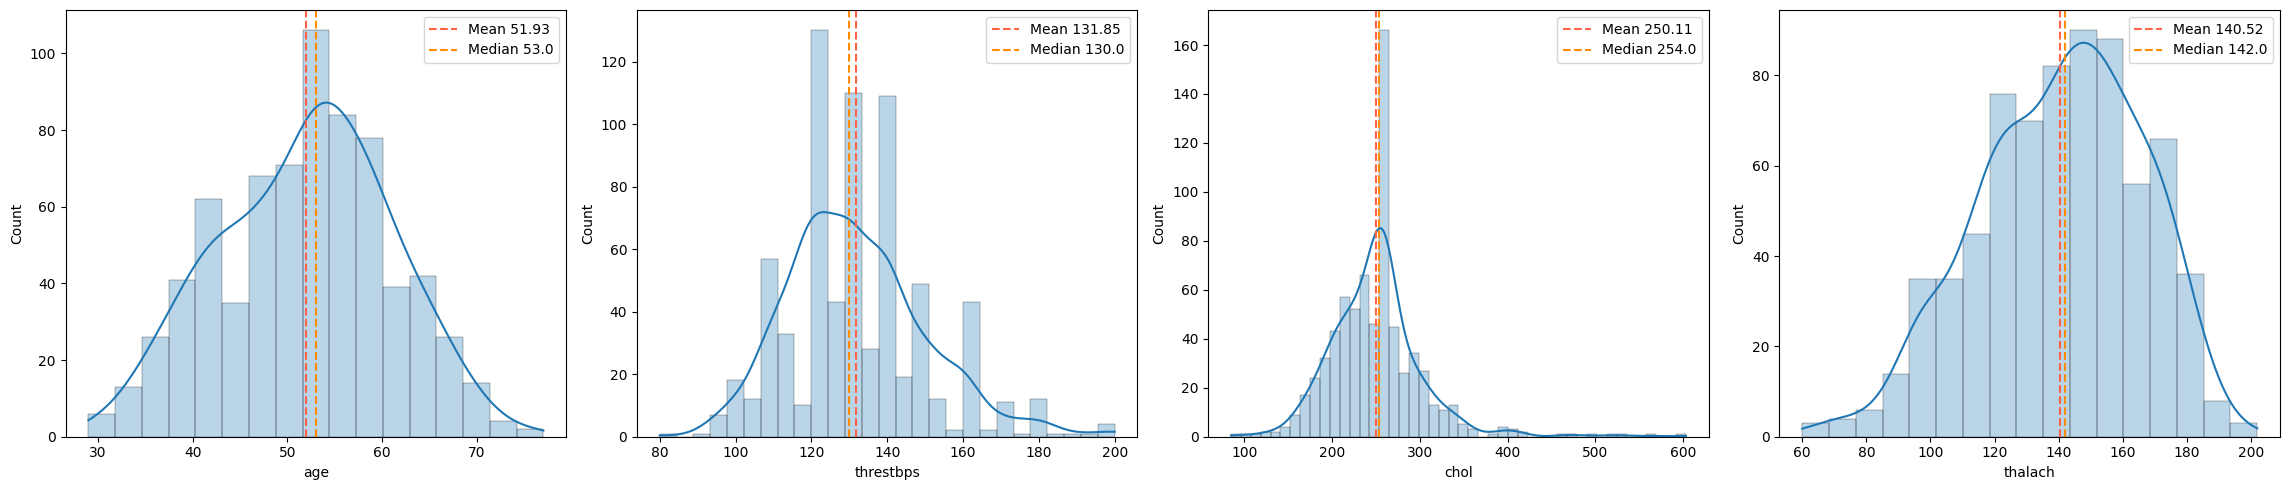

In [ ]:
# Columnas continuas
age = df_filtered["age"]
thresh = df_filtered["threstbps"]
thalach = df_filtered["thalach"]
chol = df_filtered["chol"]

fig,axs = plt.subplots(1,4,figsize=(23,5))

sns.histplot(age,ax=axs[0],alpha=0.3,lw=0.2,kde=True)
axs[0].axvline(age.mean(),ls="dashed",color="tomato",label=f"Mean {round(age.mean(),2)}")
axs[0].axvline(age.median(),ls="dashed",color="darkorange",label=f"Median {round(age.median(),2)}")
axs[0].legend()

sns.histplot(thresh,ax=axs[1],alpha=0.3,lw=0.2,kde=True)
axs[1].axvline(thresh.mean(),ls="dashed",color="tomato",label=f"Mean {round(thresh.mean(),2)}")
axs[1].axvline(thresh.median(),ls="dashed",color="darkorange",label=f"Median {round(thresh.median(),2)}")
axs[1].legend()

sns.histplot(chol,ax=axs[2],alpha=0.3,lw=0.2,kde=True)
axs[2].axvline(chol.mean(),ls="dashed",color="tomato",label=f"Mean {round(chol.mean(),2)}")
axs[2].axvline(chol.median(),ls="dashed",color="darkorange",label=f"Median {round(chol.median(),2)}")
axs[2].legend()

sns.histplot(thalach,ax=axs[3],alpha=0.3,lw=0.2,kde=True)
axs[3].axvline(thalach.mean(),ls="dashed",color="tomato",label=f"Mean {round(thalach.mean(),2)}")
axs[3].axvline(thalach.median(),ls="dashed",color="darkorange",label=f"Median {round(thalach.median(),2)}")
axs[3].legend()

plt.tight_layout()
plt.show()

Observamos que las distribuciones de las variables continuas se acercan a una distribución normal, de los cuales podemos extraer como datos interesantes las medianas de 53 años de edad, un threstbps de 130, niveles de colesterol cercanos a 254 y un thalach de 142.

Graficamos las categoricas

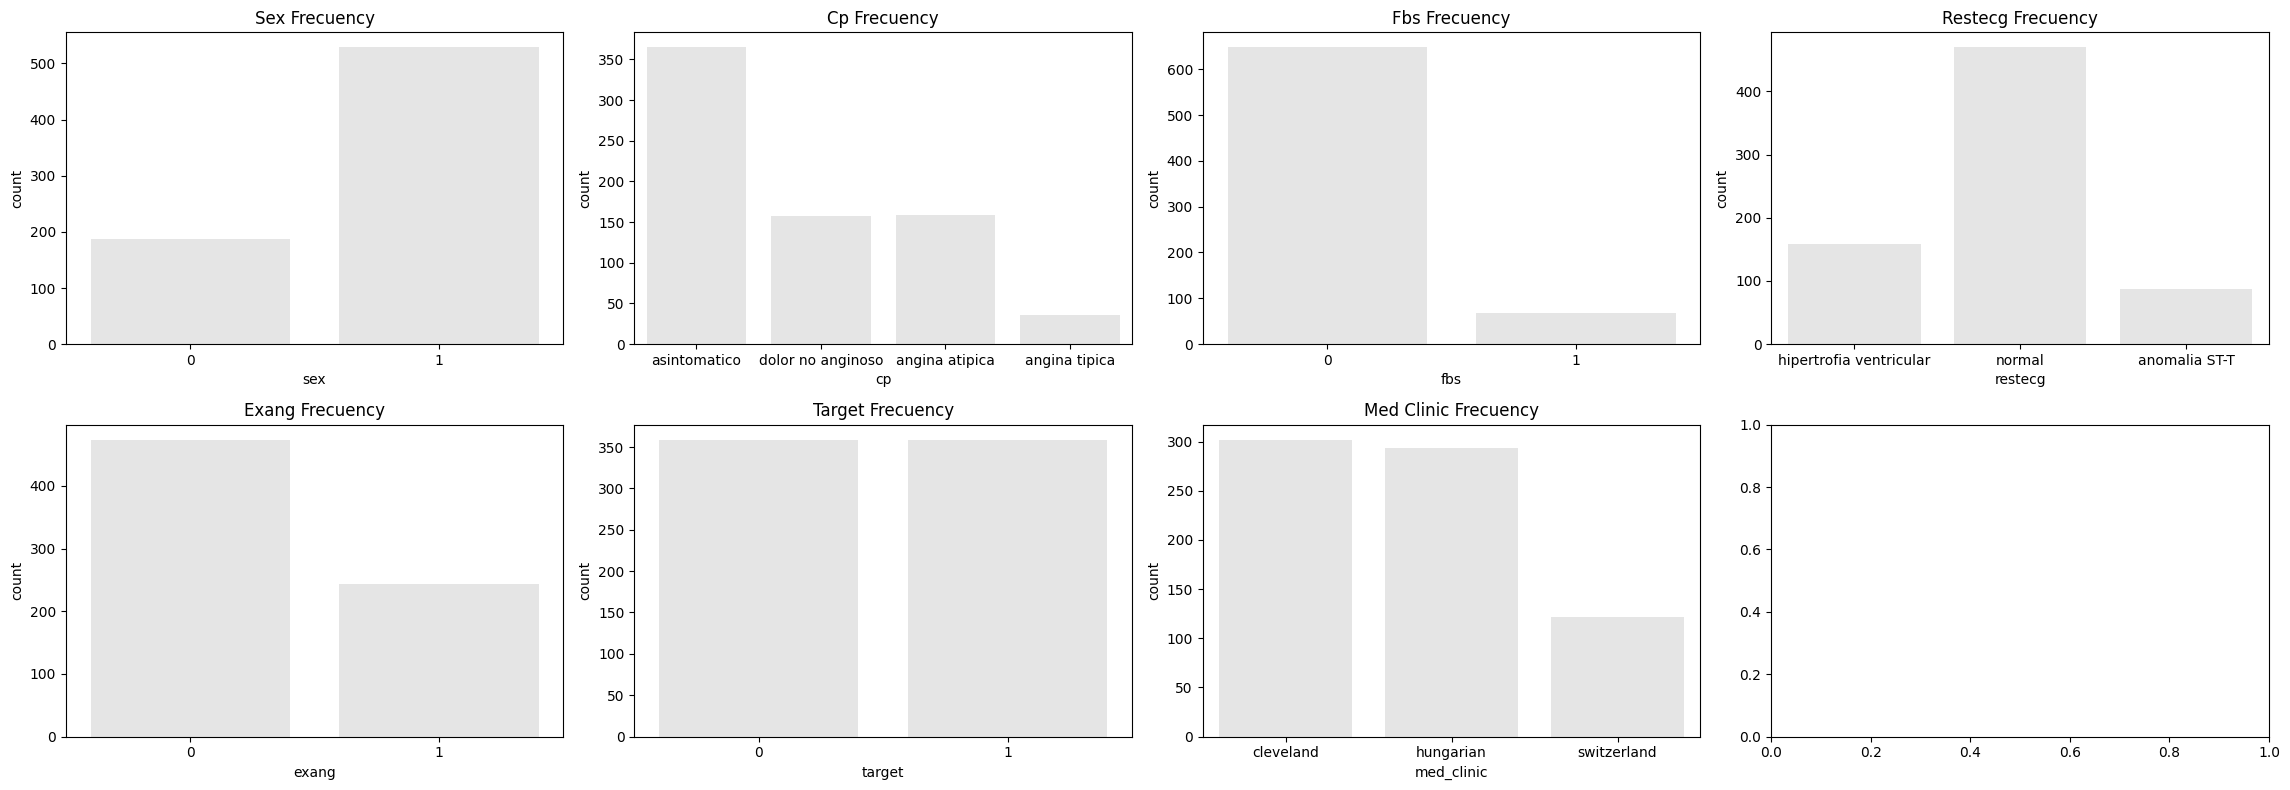

In [ ]:
# Columnas categóricas
sex = df_filtered["sex"]
cp = df_filtered["cp"]
fbs = df_filtered["fbs"]
restecg = df_filtered["restecg"]
exang = df_filtered["exang"]
target = df_filtered["target"]
med_clinic = df_filtered["med_clinic"]

fig,axs = plt.subplots(2,4,figsize=(23,8))

sns.countplot(data=df_filtered, color="darkgrey",x=sex, alpha=0.3, lw=0.4, ax=axs[0, 0])
axs[0,0].set_title("Sex Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=cp, alpha=0.3, lw=0.4, ax=axs[0, 1])
axs[0,1].set_title("Cp Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=fbs, alpha=0.3, lw=0., ax=axs[0, 2])
axs[0,2].set_title("Fbs Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=restecg, alpha=0.3, lw=0.4, ax=axs[0, 3])
axs[0,3].set_title("Restecg Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=exang, alpha=0.3, lw=0.4, ax=axs[1, 0])
axs[1,0].set_title("Exang Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=target, alpha=0.3, lw=0.4, ax=axs[1, 1])
axs[1,1].set_title("Target Frecuency")

sns.countplot(data=df_filtered, color="darkgrey",x=med_clinic, alpha=0.3, lw=0.4, ax=axs[1, 2])
axs[1,2].set_title("Med Clinic Frecuency")

plt.tight_layout()
plt.show()



*   Más del 70% de los registros corresponden a Hombres.
*   Un 50% de los pacientes registrados no presentaban sintomas de ningun tipo
*   Un 90% de los pacientes contaba con niveles de glucemia bajo 120mg/dl
*   Un 65% de los pacientes tienen mediciones electrocardiografica normales
*   Un 66% No tiene Angina inducida por el ejercicio
*   No existe un desbalance de clase, es 51-49%
*   Las clinicas de cleveland y hungarian son las que más registros aportan a la base de datos

In [ ]:
#Solo para complementar los graficos, no es necesario ejecutar
for col in df_filtered:
  print(df[col].value_counts("%"))
  print()

age
54    0.061367
52    0.047420
58    0.043236
56    0.040446
51    0.039052
57    0.039052
53    0.039052
55    0.037657
59    0.037657
48    0.037657
50    0.032078
43    0.032078
46    0.030683
41    0.030683
60    0.027894
49    0.027894
62    0.027894
47    0.026499
61    0.026499
44    0.025105
45    0.023710
42    0.023710
38    0.020921
65    0.020921
39    0.020921
63    0.019526
64    0.018131
40    0.015342
35    0.013947
67    0.013947
37    0.013947
66    0.013947
34    0.009763
70    0.008368
36    0.008368
68    0.008368
69    0.006974
32    0.005579
71    0.004184
29    0.004184
31    0.002789
33    0.002789
74    0.002789
30    0.001395
76    0.001395
77    0.001395
72    0.001395
73    0.001395
Name: proportion, dtype: float64

sex
1    0.737796
0    0.262204
Name: proportion, dtype: float64

cp
4    0.509066
2    0.221757
3    0.218968
1    0.050209
Name: proportion, dtype: float64

threstbps
120.0    0.161064
130.0    0.138655
140.0    0.128852
110.0    0.070028
1

**Calculo de correlaciones**

In [ ]:
#Usaremos solo las variables continuas
df_heat = df_filtered[["age","threstbps","chol","thalach","target"]]
#Calculamos la correlacion de Pearson
df_corr = df_heat.corr()


<Axes: >

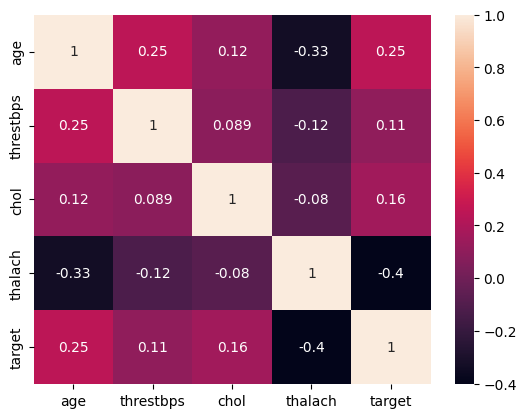

In [ ]:
sns.heatmap(data=df_corr,annot=True)

**Podemos visualizar correlaciones no necesariamente altas entre las variables numericas y contra el target, sin embargo algo rescatable es que no se detecta multicolinealidad por excesiva correlacion entre las variables, lo cual es bueno para luego poder entregar estas features al modelo.**

# Divide la muestra en entrenamiento y test (33%), y con ello:


*   Entrena un modelo secuencial Adaboost
*   Entrena un modelo secuencial Gradient Boosting
*   Entrena un modelo secuencial XGBoosting

Para cada uno, utiliza hiper parámetros por defecto y muestra su desempeño usando las métricas adecuadas. Comenta.




In [ ]:
#Hacemos el train test split de acuerdo a lo indicado
X = df_dummies.drop(columns="target")
y = df_dummies["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=16)

#Instanciamos los modelos default y los ajustamos
ad = AdaBoostClassifier()
ad.fit(X_train,y_train)

gb = GradientBoostingClassifier().fit(X_train,y_train)
gb.fit(X_train,y_train)

xgb = XGBClassifier().fit(X_train,y_train)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Hacemos las predicciones
def predict_metrics(model): #Definimos una funcion para optimizar codigo adelante

  model.fit(X_train,y_train)
  #Realizamos predicciones en train y test
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #================TRAIN======================================
  #Calculamos metricas de desempeño de TRAIN
  conf_matrix_train = confusion_matrix(y_train, y_pred_train)
  report_train = classification_report(y_train, y_pred_train)

  #AUC-ROC / AUC-PR TRAIN
  roc_train = roc_auc_score(y_train, y_pred_train)
  pr_train = average_precision_score(y_train, y_pred_train)

  #================TEST======================================

  #Calculamos metricas de desempeño de TEST
  conf_matrix_test = confusion_matrix(y_test, y_pred_test)
  report_test = classification_report(y_test, y_pred_test)

  #AUC-ROC / AUC-PR TRAIN
  roc_test = roc_auc_score(y_test, y_pred_test)
  pr_test = average_precision_score(y_test, y_pred_test)


  #========================= OUTPUT =========================
  print("====================EVALUACION TRAIN ===============")
  print("Matriz de Confusión: TRAIN")
  print()
  print(conf_matrix_train)
  print()
  print("Reporte de clasificacion: TRAIN")
  print(report_train)
  print(f"AUC-ROC PARA TRAIN: {roc_train}")
  print(f"AUC-PR PARA TRAIN: {pr_train}")
  print()


  print("====================EVALUACION TEST ===============")
  print("Matriz de Confusión: TEST")
  print()
  print(conf_matrix_test)
  print()
  print("Reporte de clasificacion: TEST")
  print(report_test)
  print(f"AUC-ROC PARA TEST: {roc_test}")
  print(f"AUC-PR PARA TEST: {pr_test}")

**Metricas Adaboost default**

In [ ]:
predict_metrics(ad)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[214  30]
 [ 34 202]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       244
           1       0.87      0.86      0.86       236

    accuracy                           0.87       480
   macro avg       0.87      0.87      0.87       480
weighted avg       0.87      0.87      0.87       480

AUC-ROC PARA TRAIN: 0.8664906918588496
AUC-PR PARA TRAIN: 0.8160846483537892

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[83 31]
 [25 98]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       114
           1       0.76      0.80      0.78       123

    accuracy                           0.76       237
   macro avg       0.76      0.76      0.76       237
weighted avg       0.76      0.76      0.76       237

A

**Metricas GradientBoostin default**

In [ ]:
predict_metrics(gb)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[235   9]
 [ 10 226]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       244
           1       0.96      0.96      0.96       236

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480

AUC-ROC PARA TRAIN: 0.9603709363712143
AUC-PR PARA TRAIN: 0.9417853708378411

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[90 24]
 [27 96]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       114
           1       0.80      0.78      0.79       123

    accuracy                           0.78       237
   macro avg       0.78      0.78      0.78       237
weighted avg       0.79      0.78      0.78       237

A

**Metricas XGBoosting default**

In [ ]:
predict_metrics(xgb)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[244   0]
 [  0 236]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       236

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

AUC-ROC PARA TRAIN: 1.0
AUC-PR PARA TRAIN: 1.0

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[91 23]
 [30 93]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       114
           1       0.80      0.76      0.78       123

    accuracy                           0.78       237
   macro avg       0.78      0.78      0.78       237
weighted avg       0.78      0.78      0.78       237

AUC-ROC PARA TEST: 0.7771715875

**Conclusiones modelos default:**



*   Los 3 modelos cuentan con desempeños bastante buenos tanto en train como en test.
*   Se destacan las métricas del XGBoosting, sin embargo su buen desempeño en train puede deberse a overfitting, aunque por la naturaleza del modelo deberia justamente reducir este. En test tambien podemos ver las mejores metricas en AUC ROC Y PR en este mismo modelo.
*   Los f1 score de los 3 modelos en test son bastante similares, sin embargo ADA tiene mejor recall a la hora de detectar con mayor sensibilidad la clase 1 del target.
*  Gradient boosting tiene menor errores del tipo 1 y 2 en train y en test (omitiendo los valores 1 absolutos del XGB en train).

Con la busqueda de hiperparametros lograremos visualizar de mejor manera que modelo es mejor.







# 3.Realiza una búsqueda del hiper parámetro para el modelo que resulte tener mejor desempeño (utiliza f1-score para determinarlo). Los valores a buscar para la grilla son:



*   a. n_estimators: 20 a 200 con 15 valores
*   b. learning_rate: 0.004 a 1.0 con 40 valores
*   c. sub_sample: 0.1 a 1.0 con 18 valores



**DISCLAIMER: ADABOOSTING y GRADIENT BOOSTING NO ADMITE SUB_SAMPLE, POR LO QUE SE LE HARÁ UNA GRILLA DISTINTA RESPETANDO LO INDICADO EN EL DESAFIO**

In [ ]:
%%time
ada_gr_params = {"n_estimators": np.linspace(20,200,15).astype(int),
                "learning_rate": np.linspace(0.004,1.0,40)}

#Grilla ADA
ada_grid_search = GridSearchCV(ad,ada_gr_params,scoring="f1",n_jobs=-1,cv=5)#Aplicamos validacion cruzada
ada_grid_search.fit(X_train,y_train)

#Resultados
ada_best_params = ada_grid_search.best_params_
ada_best_score = ada_grid_search.best_score_
print("Best params Ada:",ada_best_params)
print("Best score:",ada_best_score)

Best params Ada: {'learning_rate': 0.029538461538461538, 'n_estimators': 161}
Best score: 0.8358593747811849
CPU times: user 12.9 s, sys: 1.54 s, total: 14.4 s
Wall time: 10min 40s


In [ ]:
%%time
#Grilla GBoosting
gb_grid_search = GridSearchCV(gb,ada_gr_params,scoring="f1",n_jobs=-1,cv=5)#Aplicamos validacion cruzada
gb_grid_search.fit(X_train,y_train)

#Resultados
gb_best_params = gb_grid_search.best_params_
gb_best_score = gb_grid_search.best_score_
print("Best params GB:",gb_best_params)
print("Best score:",gb_best_score)

Best params Ada: {'learning_rate': 0.05507692307692308, 'n_estimators': 45}
Best score: 0.8522973351908764
CPU times: user 7.84 s, sys: 853 ms, total: 8.69 s
Wall time: 5min 57s


In [ ]:
%%time
xgb_params = {"n_estimators": np.linspace(20, 200, 15).astype(int),
                "learning_rate": np.linspace(0.004,1.0,40),
                "subsample": np.linspace(0.1,1.0,18)} #Aqui hay que sacar el _ , o sino el modelo no lo aplica y arroja warning


#Grilla XGB
xgb_grid_search = GridSearchCV(xgb,xgb_params,scoring="f1",n_jobs=-1,cv=3)#Aplicamos validacion cruzada
xgb_grid_search.fit(X_train,y_train)

#Resultados
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_
print("Best params XGB:",xgb_best_params)
print("Best score:",xgb_best_score)

Best params Ada: {'learning_rate': 0.08061538461538462, 'n_estimators': 135, 'subsample': 0.1}
Best score: 0.8483969893178155
CPU times: user 60 s, sys: 3.33 s, total: 1min 3s
Wall time: 24min 28s


**Entrenamos los modelos a partir de sus hiperparametros**

In [ ]:
ada_opt = AdaBoostClassifier(**ada_best_params,random_state=16)
ada_opt.fit(X_train,y_train)

gb_opt = GradientBoostingClassifier(**gb_best_params,random_state=16)
gb_opt.fit(X_train,y_train)

xgb_opt = XGBClassifier(**xgb_best_params,random_state=16)
xgb_opt.fit(X_train,y_train)

**Obtenemos su desempeño**

In [ ]:
predict_metrics(ada_opt)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[206  38]
 [ 36 200]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       244
           1       0.84      0.85      0.84       236

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480

AUC-ROC PARA TRAIN: 0.8458599611003056
AUC-PR PARA TRAIN: 0.7871492664862556

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[ 87  27]
 [ 23 100]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       114
           1       0.79      0.81      0.80       123

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       23

In [ ]:
predict_metrics(gb_opt)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[223  21]
 [ 28 208]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       244
           1       0.91      0.88      0.89       236

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480

AUC-ROC PARA TRAIN: 0.8976451792164488
AUC-PR PARA TRAIN: 0.8588662324525695

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[90 24]
 [25 98]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       114
           1       0.80      0.80      0.80       123

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237

A

In [ ]:
predict_metrics(xgb)

====================EVALUACION TRAIN ===============
Matriz de Confusión: TRAIN

[[244   0]
 [  0 236]]

Reporte de clasificacion: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       236

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

AUC-ROC PARA TRAIN: 1.0
AUC-PR PARA TRAIN: 1.0

====================EVALUACION TEST ===============
Matriz de Confusión: TEST

[[91 23]
 [30 93]]

Reporte de clasificacion: TEST
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       114
           1       0.80      0.76      0.78       123

    accuracy                           0.78       237
   macro avg       0.78      0.78      0.78       237
weighted avg       0.78      0.78      0.78       237

AUC-ROC PARA TEST: 0.7771715875

# 4.Elabora un gráfico con las curvas ROC para cada modelo entrenado, y a partir de ello recomienda alguno de ellos. Justifica la decisión.

In [ ]:
#Predicciones de cada modelo optimizado en test
y_pred_ada = ada_opt.predict(X_test)
y_pred_gb = gb_opt.predict(X_test)
y_pred_xgb = xgb_opt.predict(X_test)


#Primero calculamos los fpr y tpr y compararemos el rendimiento de los 3 en TEST
fpr_test_ada, tpr_test_ada, _ = roc_curve(y_test, y_pred_ada)
fpr_test_gb, tpr_test_gb, _ = roc_curve(y_test, y_pred_gb)
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_pred_xgb)

# Calculamos precision y recall para graficar AUC-PR
precision_test_ada, recall_test_ada, _ = precision_recall_curve(y_test, y_pred_ada)
precision_test_gb, recall_test_gb, _ = precision_recall_curve(y_test, y_pred_gb)
precision_test_xgb, recall_test_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)

#Almacenamos los resultados de ROC Y PR por cada modelo
roc_test_ada = roc_auc_score(y_test, y_pred_ada)
pr_test_ada = average_precision_score(y_test, y_pred_ada)

roc_test_gb = roc_auc_score(y_test, y_pred_gb)
pr_test_gb = average_precision_score(y_test, y_pred_gb)

roc_test_xgb = roc_auc_score(y_test, y_pred_xgb)
pr_test_xgb = average_precision_score(y_test, y_pred_xgb)

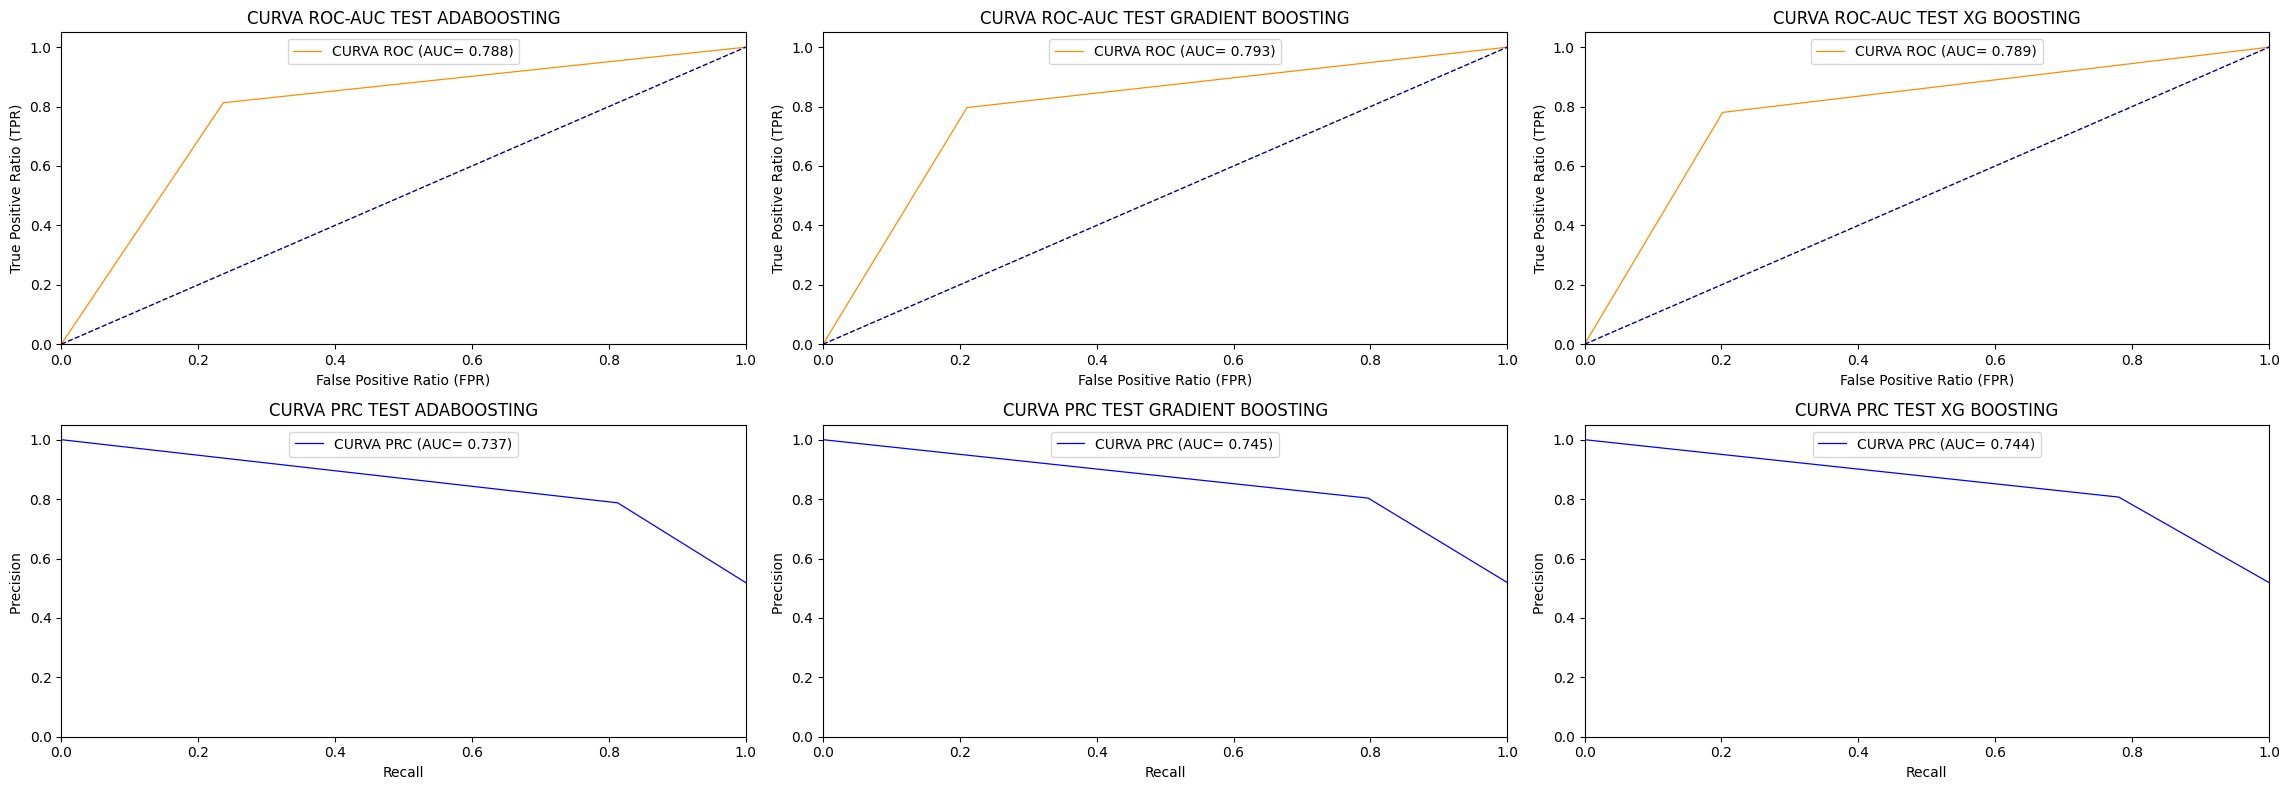

In [ ]:
#Graficamos
fig, axs = plt.subplots(2, 3, figsize=(23, 8))

# AUC-ROC TEST ADA
axs[0, 0].plot(fpr_test_ada, tpr_test_ada, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_test_ada)
axs[0, 0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Ratio (FPR)")
axs[0, 0].set_ylabel("True Positive Ratio (TPR)")
axs[0, 0].set_title("CURVA ROC-AUC TEST ADABOOSTING")
axs[0, 0].legend(loc="upper center")

# AUC-PR TEST ADA
axs[1, 0].plot(recall_test_ada, precision_test_ada, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_test_ada)
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].set_xlabel("Recall")
axs[1, 0].set_ylabel("Precision ")
axs[1, 0].set_title("CURVA PRC TEST ADABOOSTING")
axs[1, 0].legend(loc="upper center")

# AUC-ROC TEST GRADIENT B
axs[0, 1].plot(fpr_test_gb, tpr_test_gb, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_test_gb)
axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlabel("False Positive Ratio (FPR)")
axs[0, 1].set_ylabel("True Positive Ratio (TPR)")
axs[0, 1].set_title("CURVA ROC-AUC TEST GRADIENT BOOSTING")
axs[0, 1].legend(loc="upper center")

# AUC-PR TEST GRADIENT B
axs[1, 1].plot(recall_test_gb, precision_test_gb, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_test_gb)
axs[1, 1].set_xlim([0.0, 1.0])
axs[1, 1].set_ylim([0.0, 1.05])
axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision ")
axs[1, 1].set_title("CURVA PRC TEST GRADIENT BOOSTING")
axs[1, 1].legend(loc="upper center")

# AUC-ROC TEST XGB
axs[0, 2].plot(fpr_test_xgb, tpr_test_xgb, color="darkorange", lw=0.9,
               label="CURVA ROC (AUC= %0.3f)" % roc_test_xgb)
axs[0, 2].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0, 2].set_xlim([0.0, 1.0])
axs[0, 2].set_ylim([0.0, 1.05])
axs[0, 2].set_xlabel("False Positive Ratio (FPR)")
axs[0, 2].set_ylabel("True Positive Ratio (TPR)")
axs[0, 2].set_title("CURVA ROC-AUC TEST XG BOOSTING")
axs[0, 2].legend(loc="upper center")

# AUC-PR TEST XGB
axs[1, 2].plot(recall_test_xgb, precision_test_xgb, color="blue",
               lw=0.9, label="CURVA PRC (AUC= %0.3f)" % pr_test_xgb)
axs[1, 2].set_xlim([0.0, 1.0])
axs[1, 2].set_ylim([0.0, 1.05])
axs[1, 2].set_xlabel("Recall")
axs[1, 2].set_ylabel("Precision ")
axs[1, 2].set_title("CURVA PRC TEST XG BOOSTING")
axs[1, 2].legend(loc="upper center")


plt.tight_layout()
plt.show()

Eleccion del modelo: Nos decantaremos por el modelo Gradient Boosting Optimizado, ya que presenta un buen f1 score de 80%, además sus métricas de AUC-ROC y AUC-PR en test, nos revelan una mejor capacidad para poder clasificar las clases, sin embargo, los otros modelos no son del todo malos, teniendo métricas cercanas.

# 5.Muestra las variables por nivel de importancia para el mejor modelo, luego de la búsqueda de hiper parámetro. Comenta.

In [ ]:
def get_importances(df,model):# Feature importances
  importances = model.feature_importances_
  columns = X_train.columns
  importances_sorted = np.argsort(importances)[::-1]

  plt.figure(figsize=(8, 6))
  bar_plot = sns.barplot(x=columns[importances_sorted], y=importances[importances_sorted],alpha=0.5)
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

<ipython-input-67-d3b43c8d77cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, ha="right")


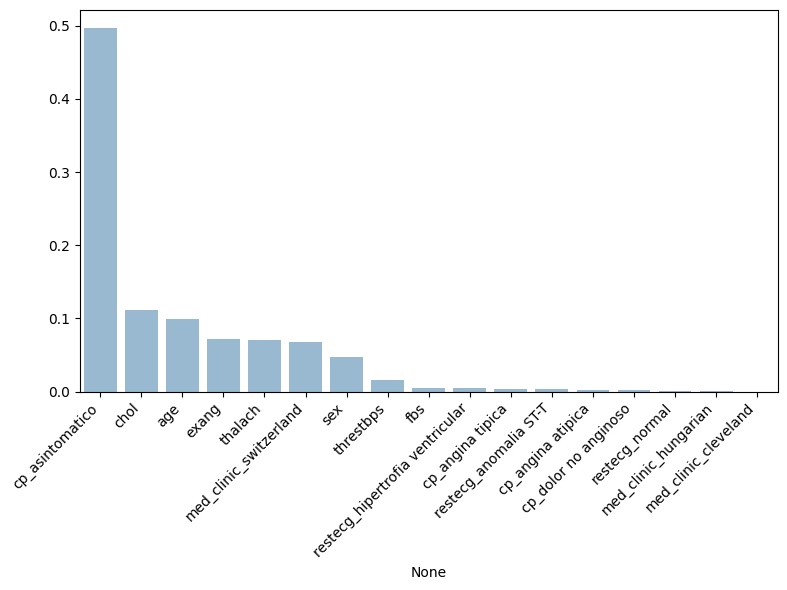

In [ ]:
get_importances(df_dummies,gb_opt)

Como podemos apreciar en el gráfico, el modelo tiende a omitir variables como CP y 2 de las clinicas, las sub categorias de restecg entre otros. Por otra parte podemos ver la poca influencia del sexo en el modelo, pero variables como si es asintomatico o no, son extremadamente relevantes, acompañado de los niveles altos de colesterol y evidentemente la edad a la hora de predecir si un paciente presenta una cardiopatía, lo cual sigue la logica y lo que podemos esperar sobre la población de avanzada edad.